# Predicting First Impressions Using Hierarchical Machine Learning



In [141]:
import pandas as pd
import numpy as np
import skimage
import matplotlib.pyplot as plt
from matplotlib import cm

rng = np.random.default_rng()

## Just loading the data...

The raw structure of the data we care about is:

- Images are in the Images directory: 'Images/*.jpg'
- Annotations are in the Annotations directory: 'Annotations/[Age, Dominance, IQ, Trustworthiness]/annotations.csv'

In [114]:
def load_images():
    import os
    img_names = os.listdir('./Images')
    data_dir = os.path.join(os.getcwd(), 'Images')
    X = []
    for img in img_names:
        img_path = os.path.join(data_dir, img)
        X.append(skimage.io.imread(img_path))
    
    print(f'Loaded {len(X)} images...')
    
    return np.asarray(X), img_names

# X, img_names = load_images()

In [117]:
def load_annotations(img_names):
    import os
    annotation_types = os.listdir('./Annotations')
    data_dir = os.path.join(os.getcwd(), 'Annotations')
    data_frames = []
    for annotation in annotation_types:
        annotation_path = os.path.join(data_dir, annotation, 'annotations.csv')
        csv = pd.read_csv(annotation_path)
        csv = csv.rename(columns={csv.columns[0]: "Image"})
        data_frames.append(csv)
    
    data_frame = data_frames[0]
    for i in range(1, len(data_frames)):
        data_frame = pd.merge(data_frame, data_frames[i], how='outer')
    
    print(f'The annotations reference {data_frame.shape[0]} images...')

    return data_frame, annotation_types

# annotations, annotation_types = load_annotations(img_names)

In [121]:
def load_cleaned_data():
    """There are images listed in the annotations that don't exist.
    So let's get rid of them and return a clean dataset."""
    X, img_names = load_images()
    annotations, annotation_types = load_annotations(img_names)
    annotations = annotations.dropna()
    mask = np.isin(img_names, annotations['Image'])

    print(f'We are deleting {len(mask) - np.sum(mask)} images...')
    print(f'Leaving a total of {np.sum(mask)} images...')

    return X[mask], np.asarray(annotations[annotation_types])

### Loading and Cleaning the data...

There are images referenced in the annotations that don't exist.
I'm simply ignoring those annotations.

There are also images that are missing one or more annotation.
I'm simply ignoring those images.

I unfortunately cannot verify that the data was correctly annotated.
But this was good enough to publish so it's good enough for me.

In [122]:
X, y = load_cleaned_data()
n = X.shape[0]

Loaded 6300 images...
The annotations reference 6420 images...
We are deleting 289 images...
Leaving a total of 6011 images...


In [123]:
print(n)
print(X.shape)
print(y.shape)

6011
(6011, 150, 130)
(6011, 4)


## What Does our Dataset Look Like?

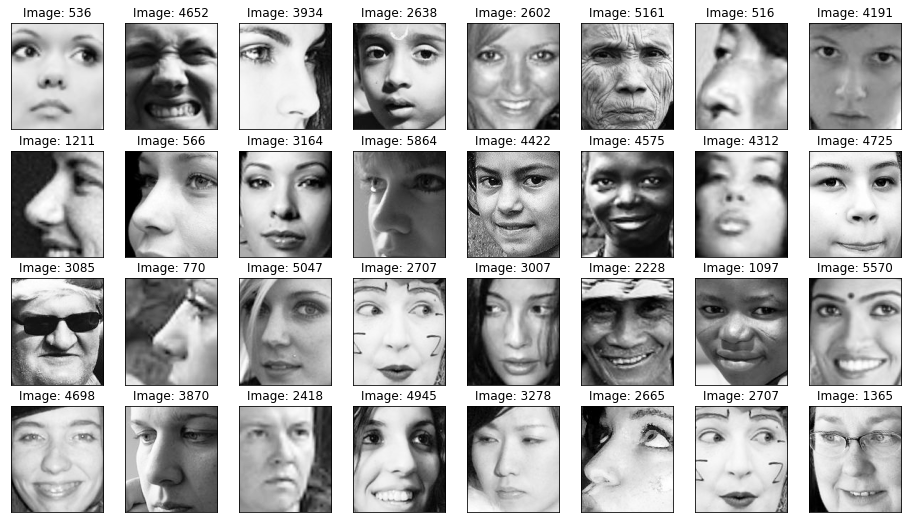

In [151]:
def plot_samples(nrows=4, ncols=8, figsize=(16,9), rseed=None):
    rng = np.random.default_rng(seed=rseed)

    num_choices = nrows*ncols
    choices = rng.choice(n, size=num_choices)
    the_chosen = X[choices]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
        subplot_kw={'xticks': [], 'yticks': []},
        figsize=(16,9))
    for i, ax in zip(range(num_choices), axs.flat):
        ax.imshow(the_chosen[i], cmap=cm.Greys_r)
        ax.set_title(f'Image: {choices[i]}')

    plt.show()

plot_samples(rseed=42)

### Observations

- The gray values go from [0, 255] == [white, black]
- Not all faces are 'frontalized'.
- This sample appears to be dominated by light skinned people.
- Position of the eyes, nose and mouth appear to be mostly equal.
- It looks like there are more people looking to the left than the right?  About 5 right, 10 left in this sample.

In [228]:
print(f'Mean pixel value: {np.mean(X):.3f}')
print(f'Median pixel value: {np.median(X):.3f}')
print(f'Standard Deviation of pixel value: {np.std(X):.3f}')
print(f'95% of pixel values fall within this range: [{np.mean(X) - np.std(X):.3f}, {np.mean(X) + np.std(X):.3f}]')

Mean pixel value: 138.867
Median pixel value: 146.000
Standard Deviation of pixel value: 64.513
95% of pixel values fall within this range: [74.354, 203.379]


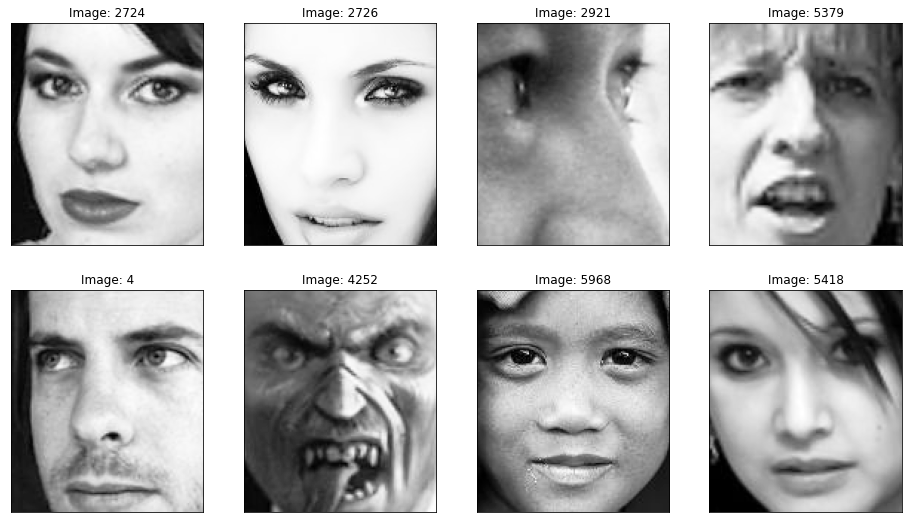

In [224]:
plot_samples(nrows=2, ncols=4)

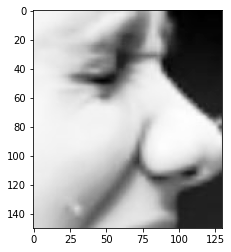

In [180]:
# Degenerate images???
degeneracies = [243, 5926, 2243]

plt.imshow(X[degeneracies[2]], cmap=cm.Greys_r)

# Visualizing statistics

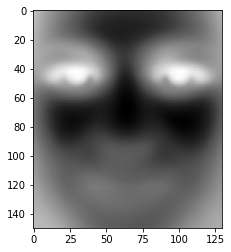

In [236]:
average_image = np.mean(X, axis=0)
plt.imshow(average_image, cmap = cm.Greys)

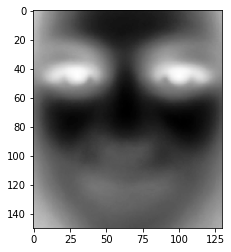

In [237]:
median_image = np.median(X, axis=0)
plt.imshow(median_image, cmap = cm.Greys)

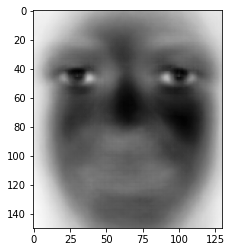

In [234]:
std_image = np.std(X, axis=0)
plt.imshow(std_image, cmap = cm.Greys_r)

### Observations

- The standard deviation indicates there is a higher variance in the values of the left cheeks of the subjects.
- All three 'statistical' images indicate that the majority of the dataset is composed of 'frontalized' faces.
- The majority of the variance in the data is in the top middle third of the images.

## Questions

- How well do regressions models perform on the entire image vs the top middle third?
- What if I just manually create some partitions of the image?  Maybe I can run separate models on each region and vote?
- Where are the principal components?

In [242]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X.reshape((X.shape[0], X.shape[1]*X.shape[2])))

PCA()
